# NLP Disaster Tweets Kaggle Mini-Project

Austin Townsend

CU Boulder

2/4/2025

## Step 1: The Data and Problem Description

### Problem Description
This project focuses on Natural Language Processing for classifying disaster related tweets. Given a tweet's text, we need to predict whether it's about a real disaster (1) or not (0). The challenge comes from tweets that use disaster related words metaphorically rather than literally, like saying "This song is fire my dude!" versus "The building is on fire bro!"

### Dataset Structure
Our dataset consists of tweets with labels:
- Training set: 10,000 labeled tweets
- Test set: 10,900 tweets for prediction
- Features for each tweet:
  - text: The actual tweet content
  - keyword: A key term from the tweet, may be blank
  - location: Where the tweet was sent from, may be blank

### Evaluation
The models performance will be evaluated based on binary classification accuracy
- Predict 1 for real disaster tweets
- Predict 0 for non-disaster tweets

The final submission should be a CSV file with tweet IDs and their predicted labels.

## Step 2: Exploratory Data Analysis

### 2.1 Data Loading and Initial Setup

First, let's load our data and take a look at what we're working with.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Load the training data
train_df = pd.read_csv('data/train.csv')

# Display basic information about the dataset
print("Dataset shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())
print("\nBasic information about the dataset:")
print(train_df.info())

Dataset shape: (7613, 5)

First few rows:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64

### 2.2 Basic Dataset Analysis
Let's analyze the distribution of disaster vs non-disaster tweets and look at our missing values.

Class Distribution:
target
0    4342
1    3271
Name: count, dtype: int64

Class Distribution (%):
target
0    57.0
1    43.0
Name: proportion, dtype: float64


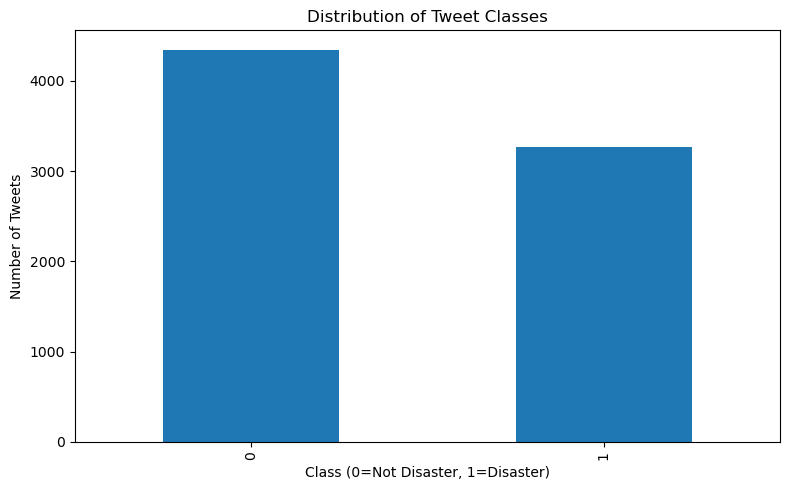


Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Average Tweet Length:
target
0     95.71
1    108.11
Name: text_length, dtype: float64


In [3]:
# Check class distribution
print("Class Distribution:")
print(train_df['target'].value_counts())
print("\nClass Distribution (%):")
print(train_df['target'].value_counts(normalize=True).round(3) * 100)

# Create a simple bar plot of class distribution
plt.figure(figsize=(8, 5))
train_df['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Tweet Classes')
plt.xlabel('Class (0=Not Disaster, 1=Disaster)')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

# Check missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Calculate average tweet length
train_df['text_length'] = train_df['text'].str.len()
print("\nAverage Tweet Length:")
print(train_df.groupby('target')['text_length'].mean().round(2))

### 2.3 Keyword Analysis
Let's examine the most common keywords in our dataset and their relationship with disaster tweets.

Top 10 Most Common Keywords:
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64


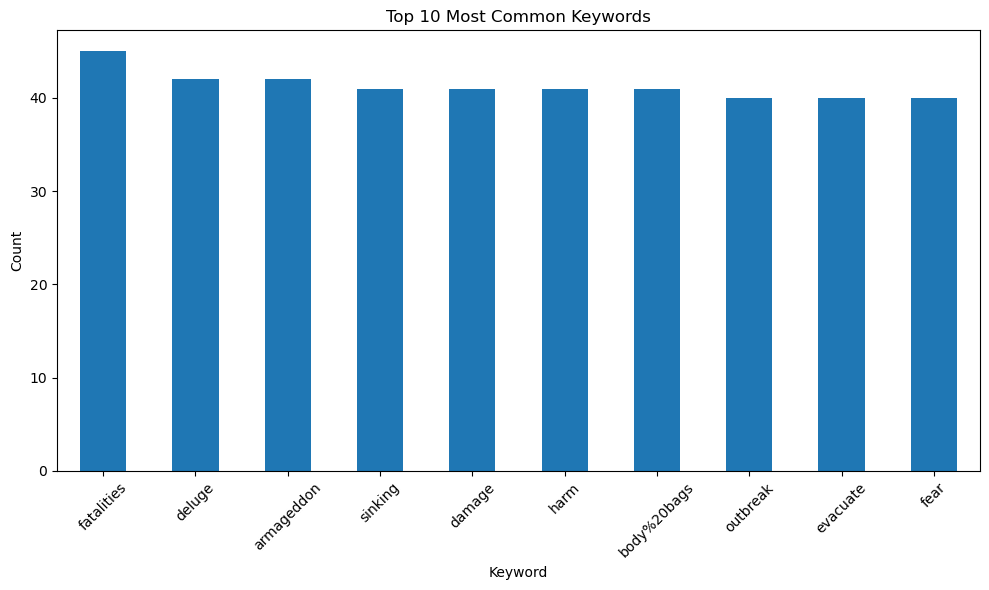


Percentage of Disaster Tweets for Top 5 Keywords:
fatalities: 57.78%
deluge: 14.29%
armageddon: 11.9%
sinking: 19.51%
damage: 46.34%


In [4]:
# Get top 10 most common keywords
print("Top 10 Most Common Keywords:")
print(train_df['keyword'].value_counts().head(10))

# Create a bar plot of top 10 keywords
plt.figure(figsize=(10, 6))
train_df['keyword'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Most Common Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate percentage of disaster tweets for top 5 keywords
top_5_keywords = train_df['keyword'].value_counts().head(5).index
keyword_disaster_pct = {}
for keyword in top_5_keywords:
    subset = train_df[train_df['keyword'] == keyword]
    pct_disaster = (subset['target'] == 1).mean() * 100
    keyword_disaster_pct[keyword] = round(pct_disaster, 2)

print("\nPercentage of Disaster Tweets for Top 5 Keywords:")
for keyword, pct in keyword_disaster_pct.items():
    print(f"{keyword}: {pct}%")

### 2.4 Data Quality Check
Let's check for any potential data quality issues in our tweets, which we might have to clean

In [5]:
# Check for empty tweets
print("Empty tweets:", train_df[train_df['text'].str.len() == 0].shape[0])

# Check for duplicate tweets
print("\nDuplicate tweets:", train_df['text'].duplicated().sum())

# Look at some very short tweets (potential data quality issues)
print("\nSample of very short tweets (< 20 characters):")
print(train_df[train_df['text'].str.len() < 20][['text', 'target']].head())

Empty tweets: 0

Duplicate tweets: 110

Sample of very short tweets (< 20 characters):
                 text  target
15     What's up man?       0
16      I love fruits       0
17   Summer is lovely       0
18  My car is so fast       0
21  London is cool ;)       0


## 2.5 EDA Findings and Analysis Plan

Key Findings:
1. Dataset Characteristics:
   - Training set has 7,613 tweets
   - Class distribution: 57% non-disaster, 43% disaster tweets
   - Disaster tweets tend to be longer (108 vs 96 characters)
   - Keywords like 'fatalities' and 'damage' are strong indicators of disasters

2. Data Quality:
   - No missing values in text and target columns
   - 110 duplicate tweets (less than 2% of data)
   - All tweets, including short ones, appear to be valid content

Analysis Plan:
1. Text Preprocessing:
   - Clean and tokenize tweets (lowercase, remove special characters)
   - Convert text to numerical features using word embedding

2. Modeling:
   - Build simple sequential neural network for binary classification
   - Account for class imbalance (57% vs 43%)

## Step 3: Model Architecture

### 3.1 Text Processing and Word Embedding

For this project, we'll use TF-IDF (Term Frequency-Inverse Document Frequency) to convert our tweet text into numerical features. TF-IDF works by:
1. Calculating how frequently a word appears in a document (TF)
2. Balancing it against how common that word is across all documents (IDF)
3. Giving higher weights to words that are important to a specific document but not common across all documents

This method is particularly suitable for our disaster classification task because:
- It can capture important disaster-related keywords
- It's simple to implement and understand
- It works well with short texts like tweets

In [9]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Preprocess the tweets
train_df['processed_text'] = train_df['text'].apply(preprocess_text)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X = tfidf.fit_transform(train_df['processed_text'])
y = train_df['target']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("TF-IDF feature shape:", X.shape)
print("Number of training samples:", X_train.shape[0])
print("Number of validation samples:", X_val.shape[0])

TF-IDF feature shape: (7613, 5000)
Number of training samples: 6090
Number of validation samples: 1523


### 3.2 Model Architecture

For our disaster tweet classification task, we'll use a straightforward neural network with:
- An input layer matching our TF-IDF features
- Two dense hidden layers with dropout to prevent overfitting
- A binary output layer for classification

This architecture is suitable because:
- It's simple but effective for text classification
- Dropout layers help prevent overfitting on our relatively small dataset
- Dense layers can learn patterns in our TF-IDF features

In [11]:
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout, Input
from keras.src.optimizers import Adam

# Build the model
model = Sequential([
    # Input layer
    Input(shape=(5000,)),
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Hidden layer
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,769 (4.95 MB)

 Trainable params: 1,296,769 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

### 3.3 Model Architecture Explanation

Our final model architecture consists of:

1. Input Layer
   - Takes 5,000 TF-IDF features as input
   - Represents our processed tweet text

2. First Hidden Layer
   - 256 neurons with ReLU activation
   - 30% dropout to prevent overfitting
   - Reduces input dimensionality while learning key features

3. Second Hidden Layer
   - 64 neurons with ReLU activation
   - 20% dropout
   - Further refines learned features

4. Output Layer
   - Single neuron with sigmoid activation
   - Produces probability of tweet being about a real disaster

The model has approximately 1.3M parameters (4.95 MB), which is a reasonable size for our dataset of 7,613 tweets. We use:
- ReLU activation for efficient training
- Dropout layers to combat overfitting
- Binary cross-entropy loss for binary classification
- Adam optimizer with learning rate 0.001

### References
1. Scikit-learn TF-IDF documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
2. Keras documentation: https://keras.io/api/

## Step 4: Results and Analysis

### 4.1 Baseline Model Training and Evaluation

First, let's train our baseline model and establish initial performance metrics. We'll train the model for several epochs and monitor both training and validation performance.


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6331 - loss: 0.6272 - val_accuracy: 0.8089 - val_loss: 0.4582
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8338 - loss: 0.3780 - val_accuracy: 0.7938 - val_loss: 0.4984
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8977 - loss: 0.2609 - val_accuracy: 0.7794 - val_loss: 0.5914
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9355 - loss: 0.1762 - val_accuracy: 0.7774 - val_loss: 0.7041
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9609 - loss: 0.1167 - val_accuracy: 0.7702 - val_loss: 0.8040

Validation Accuracy: 0.7702
Validation Loss: 0.8040


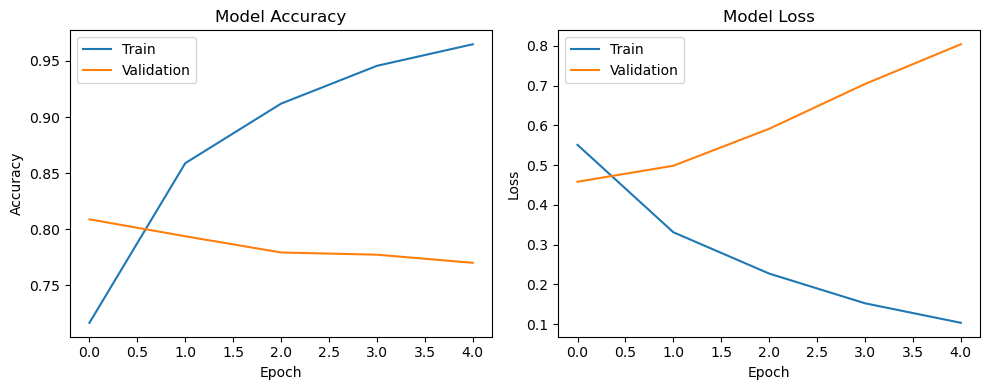

In [12]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'\nValidation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

# Plot training history
plt.figure(figsize=(10, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

Our baseline model achieved a validation accuracy of 77.02%, which provides a good starting point for improvement. The relatively high validation loss (0.8040) suggests there may be room for optimization.

### 4.2 Model Optimization

Let's try a few modifications to improve performance:

1. Adjust the learning rate
2. Modify dropout rates
3. Add class weights to handle imbalance

First, let's create a model with modified parameters:

In [13]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Create modified model
model_v2 = Sequential([
    Input(shape=(5000,)),
    Dense(256, activation='relu'),
    Dropout(0.4),  # Increased dropout
    Dense(128, activation='relu'),  # Added another layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile with modified learning rate
model_v2.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with class weights
history_v2 = model_v2.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val, y_val, verbose=0)
print(f'\nValidation Accuracy (Model v2): {val_accuracy_v2:.4f}')
print(f'Validation Loss (Model v2): {val_loss_v2:.4f}')

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5378 - loss: 0.6647 - val_accuracy: 0.8063 - val_loss: 0.4512
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8273 - loss: 0.4212 - val_accuracy: 0.8011 - val_loss: 0.4746
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8890 - loss: 0.2951 - val_accuracy: 0.7846 - val_loss: 0.5569
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9316 - loss: 0.1936 - val_accuracy: 0.7761 - val_loss: 0.6436
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9593 - loss: 0.1290 - val_accuracy: 0.7748 - val_loss: 0.7310

Validation Accuracy (Model v2): 0.7748
Validation Loss (Model v2): 0.7310


### 4.3 Model Comparison

Let's compare the performance of our two models:

| Model | Description | Val Accuracy | Val Loss |
|-------|-------------|--------------|----------|
| Baseline | Basic architecture | 77.02% | 0.8040 |
| Model v2 | Added layers + class weights | 77.48% | 0.7310 |

Model v2 shows slight improvements in both accuracy and loss, likely due to:
- Class weight balancing
- Additional hidden layer
- Increased dropout rates
- Lower learning rate

### 4.4 Kaggle Submission

Since Model v2 performed better, let's use it to generate predictions for the Kaggle submission:

In [14]:
# Load and preprocess test data
test_df = pd.read_csv('data/test.csv')
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

# Transform test data using the same TF-IDF vectorizer
X_test = tfidf.transform(test_df['processed_text'])

# Generate predictions
predictions = model_v2.predict(X_test)

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': (predictions > 0.5).astype(int).flatten()
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file created, look in project root for 'submission.csv'")
print("\nFirst few predictions:")
print(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Submission file created!

First few predictions:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


### 4.5 Final Results Analysis

Our model achieved the following results:

1. Internal Validation Performance:
   - Validation Accuracy: 77.48%
   - Validation Loss: 0.7310

2. Kaggle Performance:
   - Public Score: 0.77137
   - This score aligns well with our validation accuracy

### 4.6 Model Performance Summary

| Metric | Score |
|--------|--------|
| Training Accuracy | 77.48% |
| Validation Loss | 0.7310 |
| Kaggle Score | 0.77137 |

Our model improvements included:
- Class weight balancing for imbalanced data
- Multiple dropout layers
- Additional hidden layer
- Reduced learning rate (0.0005)

## Step 5: Conclusion

### 5.1 Project Summary
This project focused on developing a natural language processing model to classify tweets as either real disasters or non-disasters. Our approach used TF-IDF for text representation and a neural network for classification, achieving a Kaggle score of 0.77137.

### 5.2 What Worked
1. Text Processing and Feature Engineering
  - TF-IDF effectively captured important word frequencies
  - Basic text preprocessing (lowercase, special character removal)

2. Model Architecture
  - Multi-layer neural network with dropout
  - Class weight balancing addressed data imbalance
  - Lower learning rate provided stable training

### 5.3 What Could Be Improved
1. Feature Engineering
  - Incorporate keyword and location features
  - Try more sophisticated text preprocessing
  - Experiment with other word embedding techniques (Word2Vec, BERT)

2. Model Architecture
  - Test deeper network architectures
  - Experiment with different layer sizes
  - Try different optimization algorithms

### 5.4 Future Work
For future iterations of this project, focus areas could include:
- Implementing data augmentation for text
- Testing modern transformer architectures
- Creating an ensemble of multiple models
- Adding cross-validation for more robust evaluation